构建一个网络，将路透社新闻划分为 46 个互斥的主题。
* 因为有多个类别，所以这是**多分类（multiclass classification）**问题的一个例子。
* 因为每个数据点只能划分到一个类别，所以更具体地说，这是**单标签、多分类（single-label, multiclass classification）**问题的一个例子。
* 如果每个数据点可以划分到多个类别（主题），那它就是**一个多标签、多分类（multilabel,multiclass classification）**问题。


# 1 路透社数据集

路透社数据集，它包含许多短新闻及其对应的主题，由路透社在 1986 年发布。它是一个简单的、广泛使用的文本分类数据集。它包括 46 个不同的主题：某些主题的样本更多，但训练集中每个主题都有至少10个样本。

In [1]:
# 加载路透社数据集
from keras.datasets import reuters
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

Using TensorFlow backend.


`num_words=10000`将数据限定为前`10000`个最常出现的单词。我们有`8982`个训练样本和`2246`个测试样本。

In [2]:
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(8982,)
(8982,)
(2246,)
(2246,)


每个样本都是一个整数列表（表示单词索引）

In [3]:
train_data[:2]

array([list([1, 2, 2, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]),
       list([1, 3267, 699, 3434, 2295, 56, 2, 7511, 9, 56, 3906, 1073, 81, 5, 1198, 57, 366, 737, 132, 20, 4093, 7, 2, 49, 2295, 2, 1037, 3267, 699, 3434, 8, 7, 10, 241, 16, 855, 129, 231, 783, 5, 4, 587, 2295, 2, 2, 775, 7, 48, 34, 191, 44, 35, 1795, 505, 17, 12])],
      dtype=object)

In [4]:
train_labels

array([ 3,  4,  3, ..., 25,  3, 25], dtype=int64)

In [5]:
# 将索引解码为新闻文本
word_index = reuters.get_word_index()
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])
# 注意，索引减去了 3，因为 0、 1、 2 是为“padding”（填充）、
#“start of sequence”（序列开始）、“unknown”（未知词）分别保留的索引
decoded_newswire = ' '.join([reverse_word_index.get(i - 3, '?') for i in train_data[0]])

In [6]:
# 样本对应的标签是一个 0~45 范围内的整数，即话题索引编号
train_labels[10]

3

# 2 准备数据

In [7]:
# 编码数据

import numpy as np
def vectorize_sequences(sequences, dimension=10000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.
    return results

# 将训练数据向量化
x_train = vectorize_sequences(train_data)
# 将测试数据向量化
x_test = vectorize_sequences(test_data)

In [8]:
print(x_train.shape)
print(x_test.shape)

(8982, 10000)
(2246, 10000)


* 将标签向量化有两种方法：你可以将标签列表转换为整数张量，或者使用`one-hot`编码。
* **`one-hot`编码是分类数据广泛使用的一种格式，也叫分类编码`（categorical encoding）`。**

In [9]:
def to_one_hot(labels, dimension=46):
    results = np.zeros((len(labels), dimension))
    for i, label in enumerate(labels):
        results[i, label] = 1.
    return results

# 将训练标签向量化
one_hot_train_labels = to_one_hot(train_labels)
# 将测试标签向量化
one_hot_test_labels = to_one_hot(test_labels)

In [10]:
print(one_hot_train_labels.shape)
print(one_hot_test_labels.shape)

(8982, 46)
(2246, 46)


In [11]:
# # Keras 内置方法可以实现这个操作，你在 MNIST 例子中已经见过这种方法。
# from keras.utils.np_utils import to_categorical
# one_hot_train_labels = to_categorical(train_labels)
# one_hot_test_labels = to_categorical(test_labels)

# 3 构建网络

* 这个主题分类问题与前面的电影评论分类问题类似，两个例子都是对简短的文本片段进行分类。但这个问题有一个新的约束条件：输出类别的数量从`2`个变为`46`个，输出空间的维度要大得多。

* 对于前面用过的`Dense`层的堆叠，每层只能访问上一层输出的信息。如果某一层丢失了与分类问题相关的一些信息，那么这些信息无法被后面的层找回，也就是说，每一层都可能成为信息瓶颈。上一个例子使用了`16`维的中间层，但对这个例子来说 `16`维空间可能太小了，无法学会区分`46`个不同的类别。这种维度较小的层可能成为信息瓶颈，永久地丢失相关信息。

* 出于这个原因，下面将使用维度更大的层，包含`64`个单元。

In [12]:
# 模型定义
from keras import models
from keras import layers
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

In [13]:
from keras.utils import plot_model
plot_model(model,to_file='../img/03/out_three_layers2.png',show_layer_names=True,show_shapes=True)

关于这个架构还应该注意另外两点。
* 网络的最后一层是大小为`46`的`Dense`层。这意味着，对于每个输入样本，网络都会输出一个`46`维向量。这个向量的每个元素（即每个维度）代表不同的输出类别。
* 最后一层使用了`softmax`激活。**网络将输出在`46`个不同输出类别上的概率分布——对于每一个输入样本，网络都会输出一个`46`维向量，其中`output[i]`是样本属于第`i`个类别的概率**。 `46`个概率的总和为`1`。对于这个例子，最好的损失函数是`categorical_crossentropy`（分类交叉熵）。它用于衡量两个概率分布之间的距离，这里两个概率分布分别是网络输出的概率分布和标签的真实分布。通过将这两个分布的距离最小化，训练网络可使输出结果尽可能接近真实标签。

In [14]:
# 编译模型
model.compile(optimizer='rmsprop',
loss='categorical_crossentropy',
metrics=['accuracy'])

# 4 验证方法

In [15]:
# 在训练数据中留出 1000 个样本作为验证集
# 留出验证集
x_val = x_train[:1000]
partial_x_train = x_train[1000:]
y_val = one_hot_train_labels[:1000]
partial_y_train = one_hot_train_labels[1000:]

In [16]:
# 训练模型
history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 5s 661us/step - loss: 2.5322 - acc: 0.4955 - val_loss: 1.7208 - val_acc: 0.6120
Epoch 2/20
7982/7982 [==============================] - 2s 204us/step - loss: 1.4452 - acc: 0.6879 - val_loss: 1.3459 - val_acc: 0.7060
Epoch 3/20
7982/7982 [==============================] - 2s 204us/step - loss: 1.0953 - acc: 0.7651 - val_loss: 1.1708 - val_acc: 0.7430
Epoch 4/20
7982/7982 [==============================] - 2s 206us/step - loss: 0.8697 - acc: 0.8165 - val_loss: 1.0793 - val_acc: 0.7590
Epoch 5/20
7982/7982 [==============================] - 2s 207us/step - loss: 0.7034 - acc: 0.8472 - val_loss: 0.9844 - val_acc: 0.7810
Epoch 6/20
7982/7982 [==============================] - 2s 206us/step - loss: 0.5667 - acc: 0.8802 - val_loss: 0.9411 - val_acc: 0.8040
Epoch 7/20
7982/7982 [==============================] - 2s 209us/step - loss: 0.4581 - acc: 0.9048 - val_loss: 0.9083 - val_acc: 0.8020


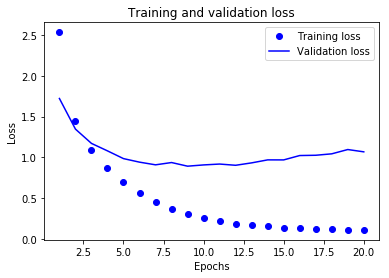

In [17]:
# 绘制损失曲线和精度曲线
%matplotlib inline
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

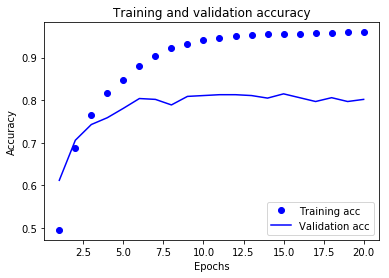

In [18]:
acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

网络在训练`9`轮后开始过拟合。我们从头开始训练一个新网络，共`9`个轮次，然后在测试集上评估模型。

In [20]:
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))

model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=9,
          batch_size=512,validation_data=(x_val, y_val))

results = model.evaluate(x_test, one_hot_test_labels)
results

Train on 7982 samples, validate on 1000 samples
Epoch 1/9
7982/7982 [==============================] - 2s 271us/step - loss: 2.6135 - acc: 0.4644 - val_loss: 1.7289 - val_acc: 0.6350
Epoch 2/9
7982/7982 [==============================] - 2s 210us/step - loss: 1.4074 - acc: 0.7082 - val_loss: 1.2747 - val_acc: 0.7310
Epoch 3/9
7982/7982 [==============================] - 2s 217us/step - loss: 1.0425 - acc: 0.7786 - val_loss: 1.1035 - val_acc: 0.7630
Epoch 4/9
7982/7982 [==============================] - 2s 203us/step - loss: 0.8180 - acc: 0.8322 - val_loss: 1.0270 - val_acc: 0.7820
Epoch 5/9
7982/7982 [==============================] - 2s 208us/step - loss: 0.6507 - acc: 0.8629 - val_loss: 0.9513 - val_acc: 0.8070
Epoch 6/9
7982/7982 [==============================] - 2s 203us/step - loss: 0.5297 - acc: 0.8904 - val_loss: 0.9206 - val_acc: 0.8120
Epoch 7/9
7982/7982 [==============================] - 2s 201us/step - loss: 0.4213 - acc: 0.9113 - val_loss: 0.9006 - val_acc: 0.8140
Epoch 8

[0.9839375222886341, 0.7858414960459524]

In [21]:
# 上述方法可以得到约 78% 的精度，如果是完全随机的精度约为 19%
import copy
test_labels_copy = copy.copy(test_labels)
np.random.shuffle(test_labels_copy)
float(np.sum(np.array(test_labels) == np.array(test_labels_copy))) / len(test_labels)

0.19056099732858414

In [23]:
# 在新数据上生成预测结果
predictions = model.predict(x_test)
predictions.shape

(2246, 46)

In [24]:
# predictions 中的每个元素都是长度为 46 的向量
predictions[0].shape

(46,)

In [26]:
# 向量的所有元素总和为 1
np.sum(predictions[0])

0.99999994

In [29]:
# 预测最大的概率
np.max(predictions[0])

0.8762773

In [30]:
# 最大的元素就是预测类别，即概率最大的类别
np.argmax(predictions[0])

3

### 中间层维度足够大的重要性

* 前面提到，最终输出是`46`维的，因此中间层的隐藏单元个数不应该比`46`小太多。现在来看一下，如果中间层的维度远远小于 `46`（比如 4 维），造成了信息瓶颈，那么会发生什么？

* 现在网络的验证精度最大约为`71%`，比前面下降了`8%`。导致这一下降的主要原因在于，你试图将大量信息（这些信息足够恢复`46`个类别的分割超平面）压缩到维度很小的中间空间。网络能够将大部分必要信息塞入这个四维表示中，但并不是全部信息。

In [31]:
# 具有信息瓶颈的模型
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(4, activation='relu'))
model.add(layers.Dense(46, activation='softmax'))
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(partial_x_train,
          partial_y_train,
          epochs=20,
          batch_size=128,
          validation_data=(x_val, y_val))

Train on 7982 samples, validate on 1000 samples
Epoch 1/20
7982/7982 [==============================] - 3s 373us/step - loss: 3.3272 - acc: 0.3980 - val_loss: 2.9791 - val_acc: 0.5090
Epoch 2/20
7982/7982 [==============================] - 2s 279us/step - loss: 2.7496 - acc: 0.4692 - val_loss: 2.7302 - val_acc: 0.3000
Epoch 3/20
7982/7982 [==============================] - 3s 315us/step - loss: 2.4512 - acc: 0.3236 - val_loss: 2.4748 - val_acc: 0.3280
Epoch 4/20
7982/7982 [==============================] - 2s 274us/step - loss: 2.1495 - acc: 0.3490 - val_loss: 2.1222 - val_acc: 0.3320
Epoch 5/20
7982/7982 [==============================] - 2s 285us/step - loss: 1.5802 - acc: 0.5423 - val_loss: 1.5323 - val_acc: 0.6420
Epoch 6/20
7982/7982 [==============================] - 2s 281us/step - loss: 1.2002 - acc: 0.6896 - val_loss: 1.4104 - val_acc: 0.6450
Epoch 7/20
7982/7982 [==============================] - 2s 284us/step - loss: 1.0927 - acc: 0.7078 - val_loss: 1.3991 - val_acc: 0.6630


这个例子中学到的要点:

* 如果要对`N`个类别的数据点进行分类，网络的最后一层应该是大小为`N`的`Dense`层。
* 对于单标签、多分类问题，网络的最后一层应该使用`softmax`激活，这样可以输出在`N`个输出类别上的概率分布。
* 这种问题的损失函数几乎总是应该使用分类交叉熵。它将网络输出的概率分布与目标的真实分布之间的距离最小化。
* 处理多分类问题的标签有两种方法。
* 通过分类编码（也叫`one-hot`编码）对标签进行编码，然后使用`categorical_crossentropy`作为损失函数。
* 将标签编码为整数，然后使用`sparse_categorical_crossentropy`损失函数。
* 如果你需要将数据划分到许多类别中，应该避免使用太小的中间层，以免在网络中造成信息瓶颈。